# ACNH Villagers: Species vs Personality
This notebook loads the villager dataset and analyzes the relationship between `Species` and `Personality`.
We'll compute association measures (chi-square / Cramér's V), mutual information, and train simple baseline classifiers to predict personality from species.

In [1]:
# If you need to install packages in this environment, uncomment and run:
# !pip install pandas numpy matplotlib seaborn scikit-learn scipy -q

In [2]:
# Imports
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency
%matplotlib inline

## Load data
Read the CSV and show basic info.

In [3]:
data_path = '../data/acnh-data/villagers.csv'
df = pd.read_csv(data_path)
print('Shape:', df.shape)
display(df.head())
df.info()

Shape: (391, 17)


,Name,Species,Gender,Personality,Hobby,Birthday,Catchphrase,Favorite Song,Style 1,Style 2,Color 1,Color 2,Wallpaper,Flooring,Furniture List,Filename,Unique Entry ID
0,Admiral,Bird,Male,Cranky,Nature,27-Jan,aye aye,Steep Hill,Cool,Cool,Black,Blue,dirt-clod wall,tatami,717;1849;7047;2736;787;5970;3449;3622;3802;410...,brd06,B3RyfNEqwGmcccRC3
1,Agent S,Squirrel,Female,Peppy,Fitness,2-Jul,sidekick,Go K.K. Rider,Active,Simple,Blue,Black,concrete wall,colorful tile flooring,7845;7150;3468;4080;290;3971;3449;1708;4756;25...,squ05,SGMdki6dzpDZyXAw5
2,Agnes,Pig,Female,Big Sister,Play,21-Apr,snuffle,K.K. House,Simple,Elegant,Pink,White,gray molded-panel wall,arabesque flooring,4129;7236;7235;7802;896;3428;4027;7325;3958;71...,pig17,jzWCiDPm9MqtCfecP
3,Al,Gorilla,Male,Lazy,Fitness,18-Oct,ayyyeee,Go K.K. Rider,Active,Active,Red,White,concrete wall,green rubber flooring,1452;4078;4013;833;4116;3697;7845;3307;3946;39...,gor08,LBifxETQJGEaLhBjC
4,Alfonso,Alligator,Male,Lazy,Play,9-Jun,it'sa me,Forest Life,Simple,Simple,Red,Blue,yellow playroom wall,green honeycomb tile,4763;3205;3701;1557;3623;85;3208;3584;4761;121...,crd00,REpd8KxB8p9aGBRSE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             391 non-null    object
 1   Species          391 non-null    object
 2   Gender           391 non-null    object
 3   Personality      391 non-null    object
 4   Hobby            391 non-null    object
 5   Birthday         391 non-null    object
 6   Catchphrase      391 non-null    object
 7   Favorite Song    391 non-null    object
 8   Style 1          391 non-null    object
 9   Style 2          391 non-null    object
 10  Color 1          391 non-null    object
 11  Color 2          391 non-null    object
 12  Wallpaper        391 non-null    object
 13  Flooring         391 non-null    object
 14  Furniture List   391 non-null    object
 15  Filename         391 non-null    object
 16  Unique Entry ID  391 non-null    object
dtypes: object(17)
memory usage: 52.1+ K

## Basic cleaning & type normalization
Trim whitespace, make `Species` and `Personality` categorical, and check missing values. Create a small subset for fast iteration if desired.

In [4]:
# Strip whitespace from column names and string values
df.columns = df.columns.str.strip()
for c in ['Species', 'Personality']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()
# Convert to categorical
df['Species'] = df['Species'].astype('category')
df['Personality'] = df['Personality'].astype('category')
# Missing values
missing = df[['Species', 'Personality']].isna().sum()
print('Missing values:', missing)
# Use a working copy for fast iteration (full df by default)
df_work = df.copy()
df_work.shape

Missing values: Species        0
Personality    0
dtype: int64


(391, 17)

## Quick exploratory stats
Value counts and contingency table for Species x Personality.

In [5]:
print('Top species:', df_work['Species'].value_counts().head())
print('Personality distribution:', df_work['Personality'].value_counts())
ct = pd.crosstab(df_work['Species'], df_work['Personality'])
display(ct.head())
# Normalized views
ct_norm_row = ct.div(ct.sum(axis=1), axis=0)
display(ct_norm_row.iloc[:10, :10])

Top species: Species
Cat         23
Rabbit      20
Squirrel    18
Frog        18
Duck        17
Name: count, dtype: int64
Personality distribution: Personality
Lazy          60
Normal        59
Jock          55
Cranky        55
Snooty        55
Peppy         49
Smug          34
Big Sister    24
Name: count, dtype: int64


Personality,Big Sister,Cranky,Jock,Lazy,Normal,Peppy,Smug,Snooty
Species,,,,,,,,
Alligator,0,1,2,2,1,0,0,1
Anteater,0,1,1,0,1,2,1,1
Bear,3,5,1,1,1,2,2,0
Bird,0,1,4,2,1,2,2,1
Bull,0,3,1,2,0,0,0,0


Personality,Big Sister,Cranky,Jock,Lazy,Normal,Peppy,Smug,Snooty
Species,,,,,,,,
Alligator,0.000000,0.142857,0.285714,0.285714,0.142857,0.000000,0.000000,0.142857
Anteater,0.000000,0.142857,0.142857,0.000000,0.142857,0.285714,0.142857,0.142857
Bear,0.200000,0.333333,0.066667,0.066667,0.066667,0.133333,0.133333,0.000000
Bird,0.000000,0.076923,0.307692,0.153846,0.076923,0.153846,0.153846,0.076923
Bull,0.000000,0.500000,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000
Cat,0.043478,0.086957,0.130435,0.130435,0.130435,0.217391,0.043478,0.217391
Chicken,0.111111,0.111111,0.111111,0.222222,0.111111,0.000000,0.111111,0.222222
Cow,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.500000
Cub,0.062500,0.125000,0.125000,0.250000,0.250000,0.125000,0.000000,0.062500


## Chi-square and Cramér's V
Run chi-square test of independence and compute Cramér's V as a measure of association between species and personality.

In [6]:
chi2, p, dof, ex = chi2_contingency(ct)
n = ct.values.sum()
phi2 = chi2 / n
r, k = ct.shape
cramers_v = np.sqrt(phi2 / min(k - 1, r - 1))
print(f'Chi2={chi2:.2f}, p={p:.3g}, dof={dof}, Cramers V={cramers_v:.3f}')

Chi2=212.97, p=0.877, dof=238, Cramers V=0.279


## Encode categorical variables for scikit-learn
We'll encode `Species` as one-hot features and `Personality` as a label target for classification and mutual information.

In [7]:
# One-hot encode species
species_ohe = pd.get_dummies(df_work['Species'], prefix='Species')
print('Species OHE shape:', species_ohe.shape)
# Encode personality as labels (target)
le_personality = LabelEncoder()
y = le_personality.fit_transform(df_work['Personality'].astype(str))
print('Personality classes:', list(le_personality.classes_))
X = species_ohe.values

Species OHE shape: (391, 35)
Personality classes: ['Big Sister', 'Cranky', 'Jock', 'Lazy', 'Normal', 'Peppy', 'Smug', 'Snooty']


## Mutual information
Compute mutual information between species one-hot features and personality target.

Species_Wolf         0.018575
Species_Bear         0.017149
Species_Rabbit       0.016668
Species_Sheep        0.016537
Species_Kangaroo     0.014917
Species_Lion         0.014740
Species_Bull         0.014337
Species_Eagle        0.013641
Species_Duck         0.013314
Species_Tiger        0.013047
Species_Elephant     0.012736
Species_Gorilla      0.009852
Species_Cow          0.009634
Species_Dog          0.008754
Species_Deer         0.008208
Species_Rhino        0.007779
Species_Squirrel     0.007421
Species_Bird         0.007414
Species_Cub          0.007135
Species_Alligator    0.006831
dtype: float64

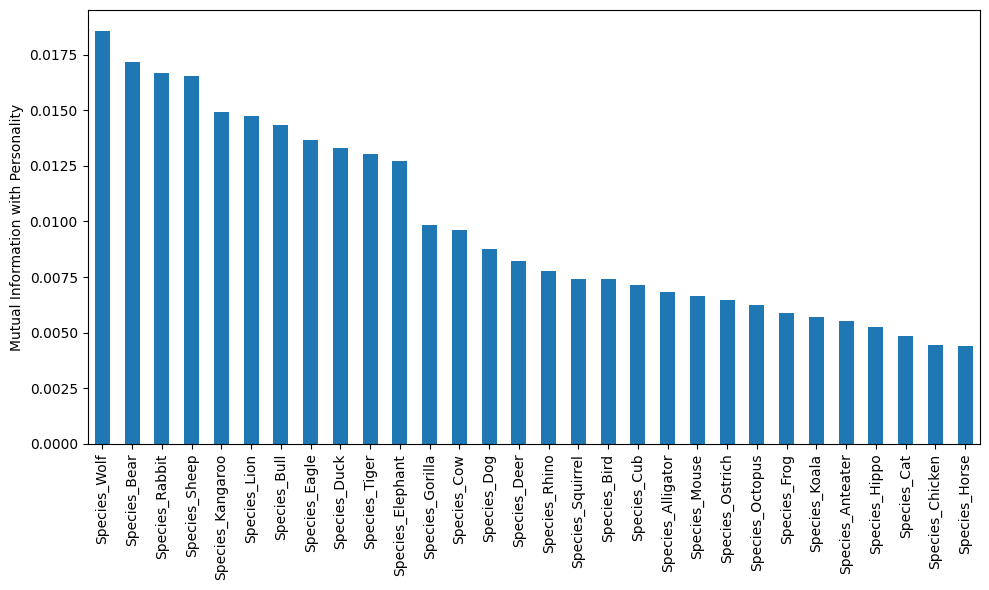

In [8]:
mi = mutual_info_classif(X, y, discrete_features=True, random_state=0)
mi_series = pd.Series(mi, index=species_ohe.columns).sort_values(ascending=False)
display(mi_series.head(20))
plt.figure(figsize=(10,6))
mi_series.head(30).plot.bar()
plt.ylabel('Mutual Information with Personality')
plt.tight_layout()
plt.show()

## Baseline classifier: predict Personality from Species
Train RandomForest and LogisticRegression baselines using species one-hot features and evaluate with stratified cross-validation.

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rf = RandomForestClassifier(n_estimators=200, random_state=0)
log = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
scores_rf = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
scores_rf_bal = cross_val_score(rf, X, y, cv=cv, scoring='balanced_accuracy')
print('RandomForest accuracy (cv):', np.mean(scores_rf).round(3), '±', np.std(scores_rf).round(3))
print('RandomForest balanced accuracy (cv):', np.mean(scores_rf_bal).round(3))
scores_lr = cross_val_score(log, X, y, cv=cv, scoring='accuracy')
print('LogisticRegression accuracy (cv):', np.mean(scores_lr).round(3))
y_pred_cv = cross_val_predict(rf, X, y, cv=cv)
print('Classification report (cross-val predictions):')
print(classification_report(y, y_pred_cv, target_names=le_personality.classes_))

RandomForest accuracy (cv): 0.143 ± 0.025
RandomForest balanced accuracy (cv): 0.127
LogisticRegression accuracy (cv): 0.151


/home/vscode/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/vscode/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/vscode/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/vscode/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was depr

Classification report (cross-val predictions):
              precision    recall  f1-score   support

  Big Sister       0.00      0.00      0.00        24
      Cranky       0.25      0.25      0.25        55
        Jock       0.15      0.18      0.17        55
        Lazy       0.14      0.13      0.14        60
      Normal       0.11      0.14      0.12        59
       Peppy       0.21      0.22      0.22        49
        Smug       0.00      0.00      0.00        34
      Snooty       0.08      0.09      0.08        55

    accuracy                           0.14       391
   macro avg       0.12      0.13      0.12       391
weighted avg       0.13      0.14      0.14       391



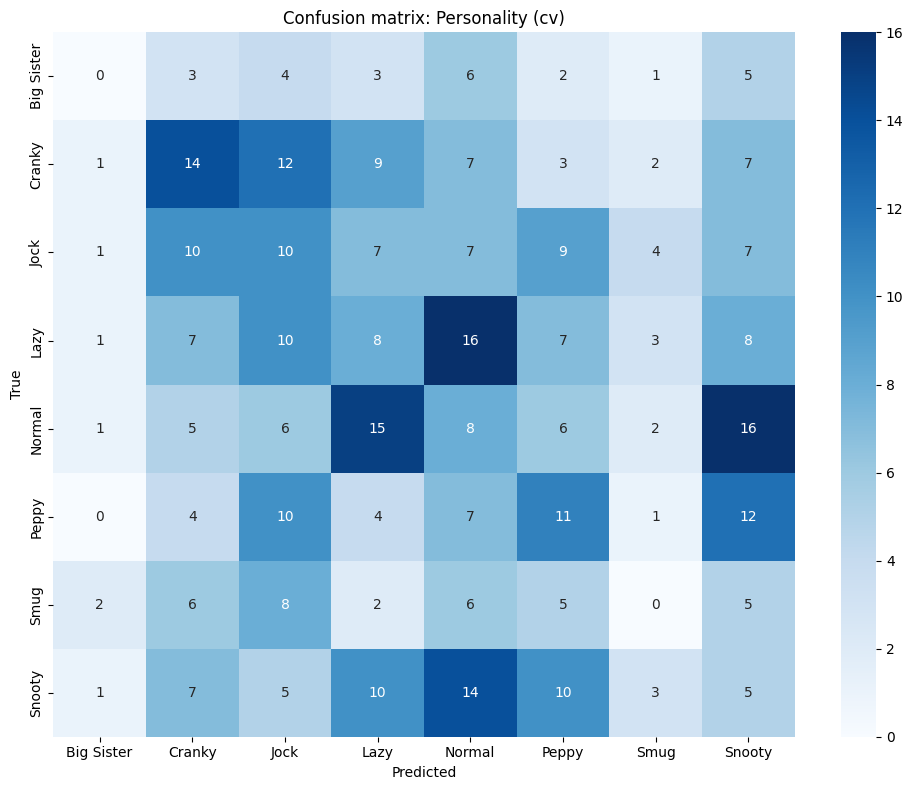

In [10]:
# Confusion matrix heatmap
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_personality.classes_, yticklabels=le_personality.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix: Personality (cv)')
plt.tight_layout()
plt.show()

## Visualize contingency table
Heatmap of species x personality counts (showing top species by count to keep the plot readable).

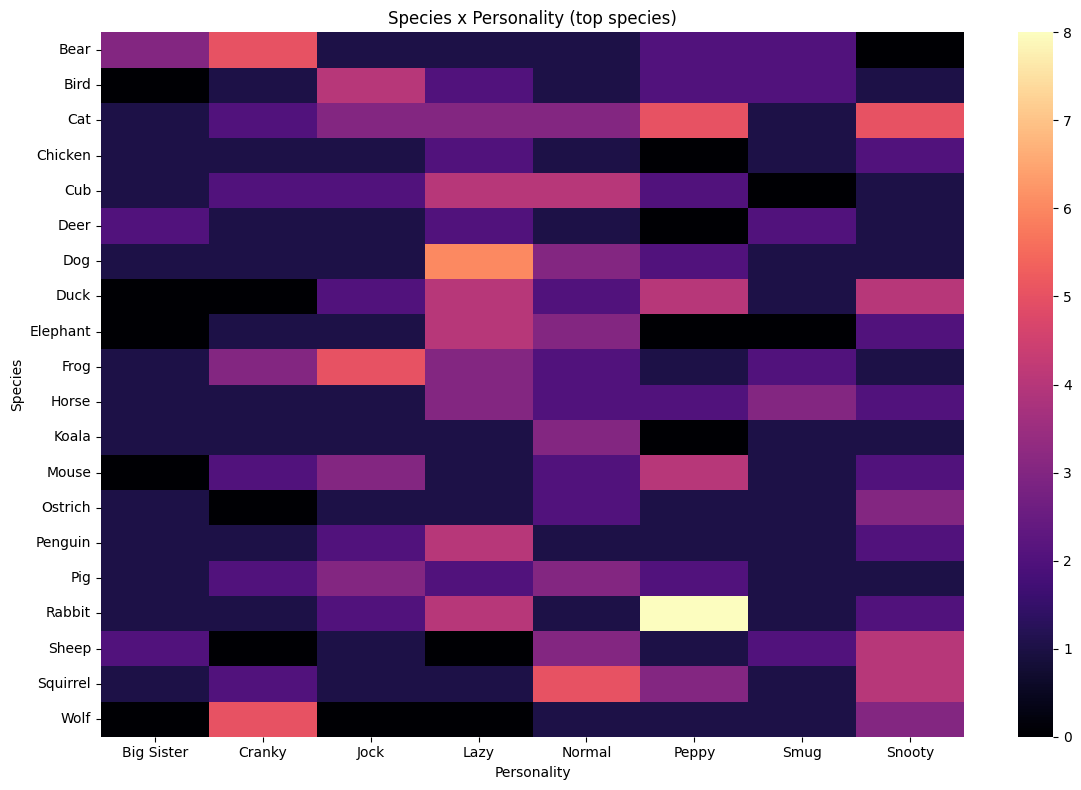

In [11]:
top_species = df_work['Species'].value_counts().nlargest(20).index
ct_top = pd.crosstab(df_work.loc[df_work['Species'].isin(top_species), 'Species'], df_work['Personality'])
plt.figure(figsize=(12,8))
sns.heatmap(ct_top, cmap='magma')
plt.title('Species x Personality (top species)')
plt.tight_layout()
plt.show()

## Save processed data and results
Save cleaned dataframe, one-hot features, the label encoder, and the RandomForest model trained on full data for later reuse.

In [12]:
out_dir = './output'
os.makedirs(out_dir, exist_ok=True)
df_work.to_csv(os.path.join(out_dir, 'villagers_cleaned.csv'), index=False)
species_ohe.to_csv(os.path.join(out_dir, 'species_ohe.csv'), index=False)

# Fit RF on full data and save
rf_full = RandomForestClassifier(n_estimators=200, random_state=0)
rf_full.fit(X, y)

# Save summary JSON
summary = {
    'n_samples': int(len(df_work)),
    'n_species': int(df_work['Species'].nunique()),
    'n_personalities': int(df_work['Personality'].nunique()),
    'cramers_v': float(cramers_v),
    'mi_top': mi_series.head(10).to_dict(),
    'rf_cv_accuracy_mean': float(np.mean(scores_rf))
}
with open(os.path.join(out_dir, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved outputs to', out_dir)

Saved outputs to ./output


## Next steps / Notes
- Current baseline predicts `Personality` from `Species` only. Consider reversing the problem or adding more features (Gender, Hobby).
- For imbalanced classes, use stratified sampling or class-weighted models.
- Use feature importance or SHAP for more interpretable models.